Concept figure on a simulated bifurcation
---

Creating panels for a concept figure

WARNING: This simulation has quite few genes (250). There is a single gene ('33'), which makes quite a difference to the projected velocities. Using 34 highly variable genes excludes this gene. If we include it, we get a backflow form the C endpoint. 

In an earlier scvelo version, this gene was also excluded when using 35 highly variable genes because of a numerical error that resulted in only 34 genes being selected, even though 35 were specified. This has been fixed. 

# Preliminaries

## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

import scvelo as scv
import scanpy as sc
import numpy as np
import cellrank as cr
from seaborn import distplot

scv.settings.verbosity = 2
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=16)
scv.settings.plot_prefix = 'concept_fig_'

# set up paths
import sys
import os
sys.path.insert(0, '../')
from paths import get_paths
file_paths = get_paths()

figdir = f"{file_paths['fig_dir']}concept_figure/new_embedding"
scv.settings.figdir = figdir
cr.settings.figdir = figdir

# from similarity import jaccard

Print package versions for reproducibility

In [2]:
scv.logging.print_version()
cr.logging.print_version_and_date()

Running scvelo 0.2.2 (python 3.8.5) on 2020-10-05 23:30.
Running CellRank 1.0.0-rc.12, on 2020-10-05 23:30.


Set up caching

In [3]:
# set up cache
import scachepy 
c = scachepy.Cache(os.path.join(file_paths['cache_dir'], 'fig_concept'),  separate_dirs=True)
c

Cache(root=/Users/marius/Projects/cellrank_notebooks_dev/notebooks/cache/fig_concept, ext='.pickle', compression='None')

## Import data

In [4]:
adata = scv.read(f"{file_paths['data_dir']}dyngen_simulation/bifurcating.h5ad")
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.96 0.04]


AnnData object with n_obs × n_vars = 1000 × 250
    obs: 'cell_id', 'from', 'to', 'time'
    uns: 'endpoints', 'gt_velocities', 'startpoints'
    obsm: 'X_emb'
    layers: 'spliced', 'unspliced'

In [5]:
adata.obs['lineage'] = adata.obs['from'].str.cat(adata.obs['to'], sep=' -> ').astype('category')
adata.obsm['X_umap'] = adata.obsm['X_emb']

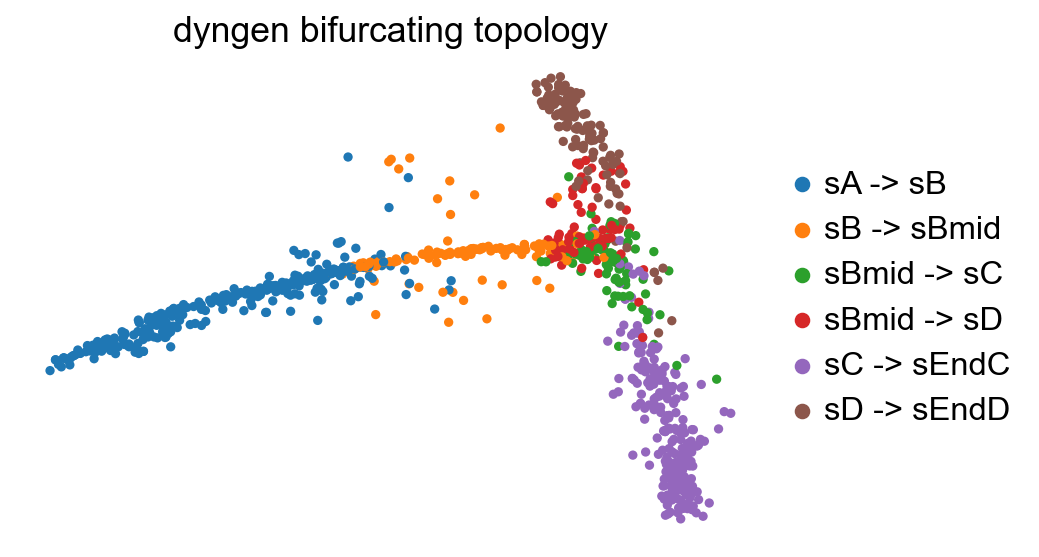

In [6]:
scv.pl.scatter(adata, basis='emb', color='lineage', legend_loc='right margin', title='dyngen bifurcating topology')

In [7]:
{lin: np.sum(adata.obs['lineage'] == lin) for lin in adata.obs['lineage'].cat.categories}

{'sA -> sB': 341,
 'sB -> sBmid': 133,
 'sBmid -> sC': 86,
 'sBmid -> sD': 78,
 'sC -> sEndC': 240,
 'sD -> sEndD': 122}

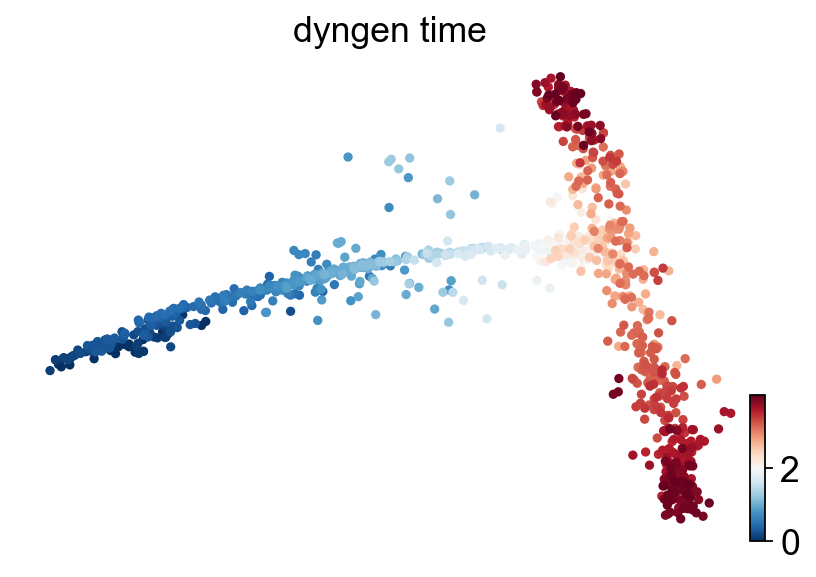

In [8]:
# define global time
adata.obs['global_time'] = adata.obs['time'].copy()

mask = adata.obs['lineage'] == 'sB -> sBmid'
adata.obs.loc[mask, 'global_time'] = adata[mask].obs['time'].copy() + 1

mask = adata.obs['lineage'] == 'sBmid -> sC'
adata.obs.loc[mask, 'global_time'] = adata[mask].obs['time'].copy() + 2

mask = adata.obs['lineage'] == 'sBmid -> sD'
adata.obs.loc[mask, 'global_time'] = adata[mask].obs['time'].copy() + 2

mask = adata.obs['lineage'] == 'sC -> sEndC'
adata.obs.loc[mask, 'global_time'] = adata[mask].obs['time'].copy() + 3

mask = adata.obs['lineage'] == 'sD -> sEndD'
adata.obs.loc[mask, 'global_time'] = adata[mask].obs['time'].copy() + 3

scv.pl.scatter(adata, color=['global_time'], title='dyngen time')

In [9]:
for ln in adata.obs['lineage']:
    mask = adata.obs['lineage'] != ln
    adata.obs[f'lin_time_{ln}'] = adata.obs['time']
    adata.obs.loc[mask, f'lin_time_{ln}'] = None

# Run basic analysis

## Compute embedding

In [10]:
# create raw object
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=3)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes
sc.pp.highly_variable_genes(adata_raw)
adata.raw = adata_raw

Normalized count data: X, spliced, unspliced.


In [11]:
# preprocessing for the actual adata object
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=34)
scv.pp.log1p(adata)

Filtered out 42 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 34 highly variable genes.


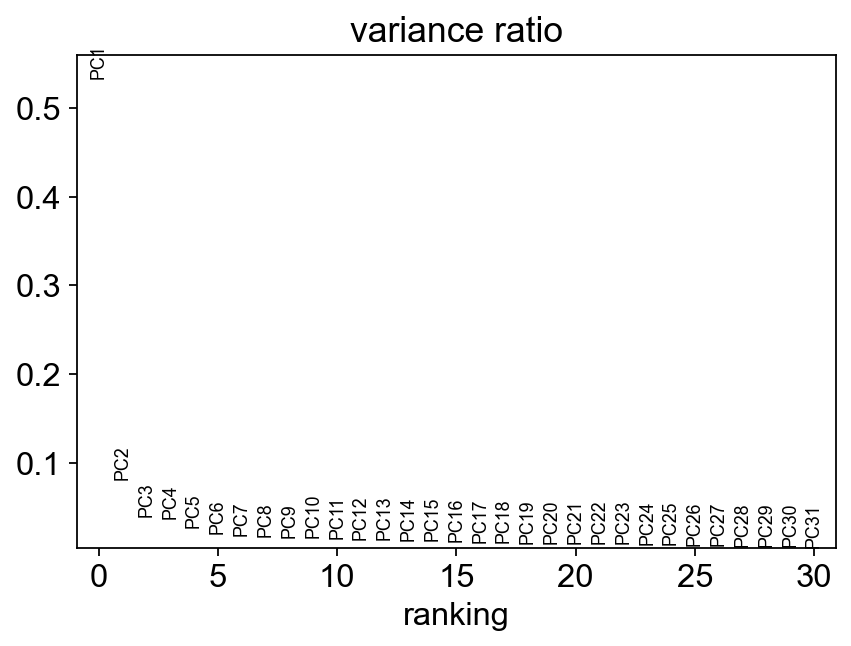

In [12]:
sc.tl.pca(adata, random_state=0)
sc.pl.pca_variance_ratio(adata)

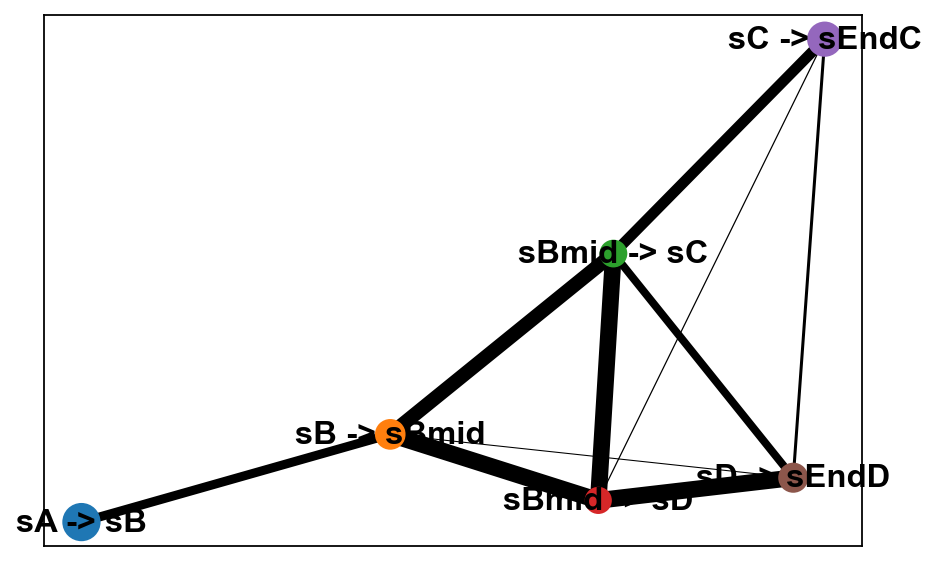

In [13]:
sc.pp.neighbors(adata, n_pcs=7, n_neighbors=15, random_state=0)
sc.tl.paga(adata, groups='lineage')
sc.pl.paga(adata, random_state=0)

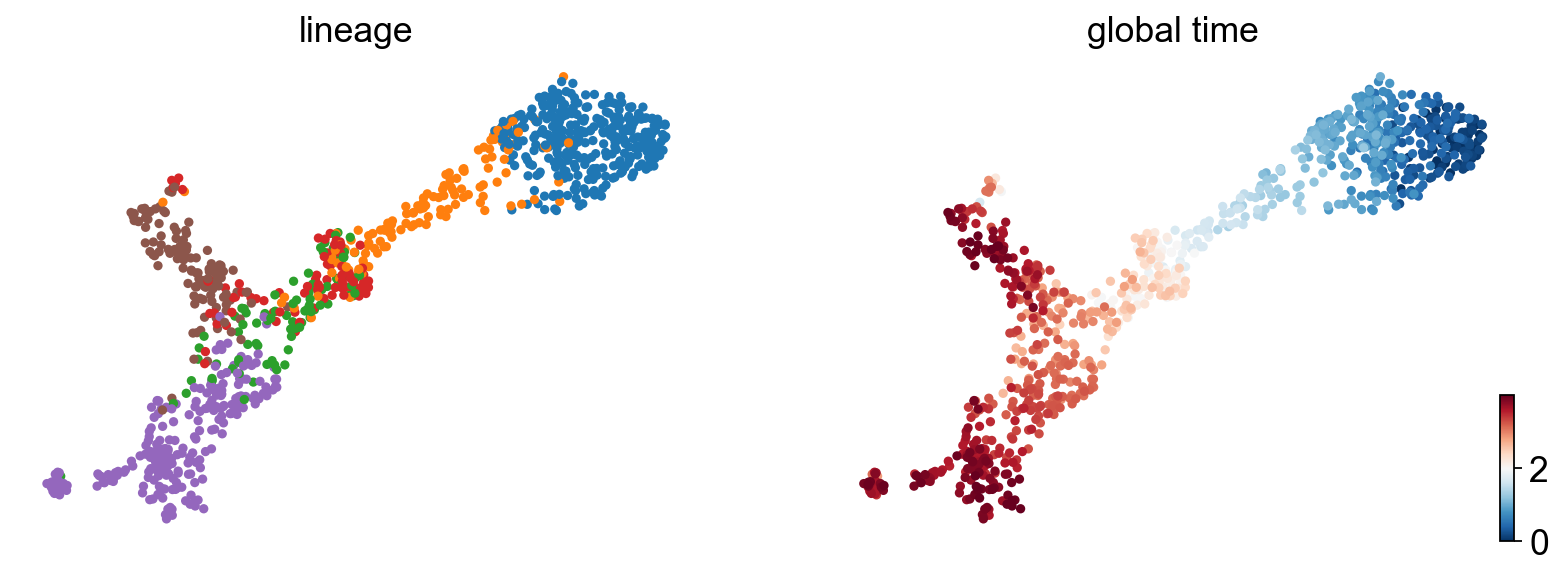

In [14]:
sc.tl.umap(adata, n_components=3, random_state=0)
scv.pl.scatter(adata, color=['lineage', 'global_time'])

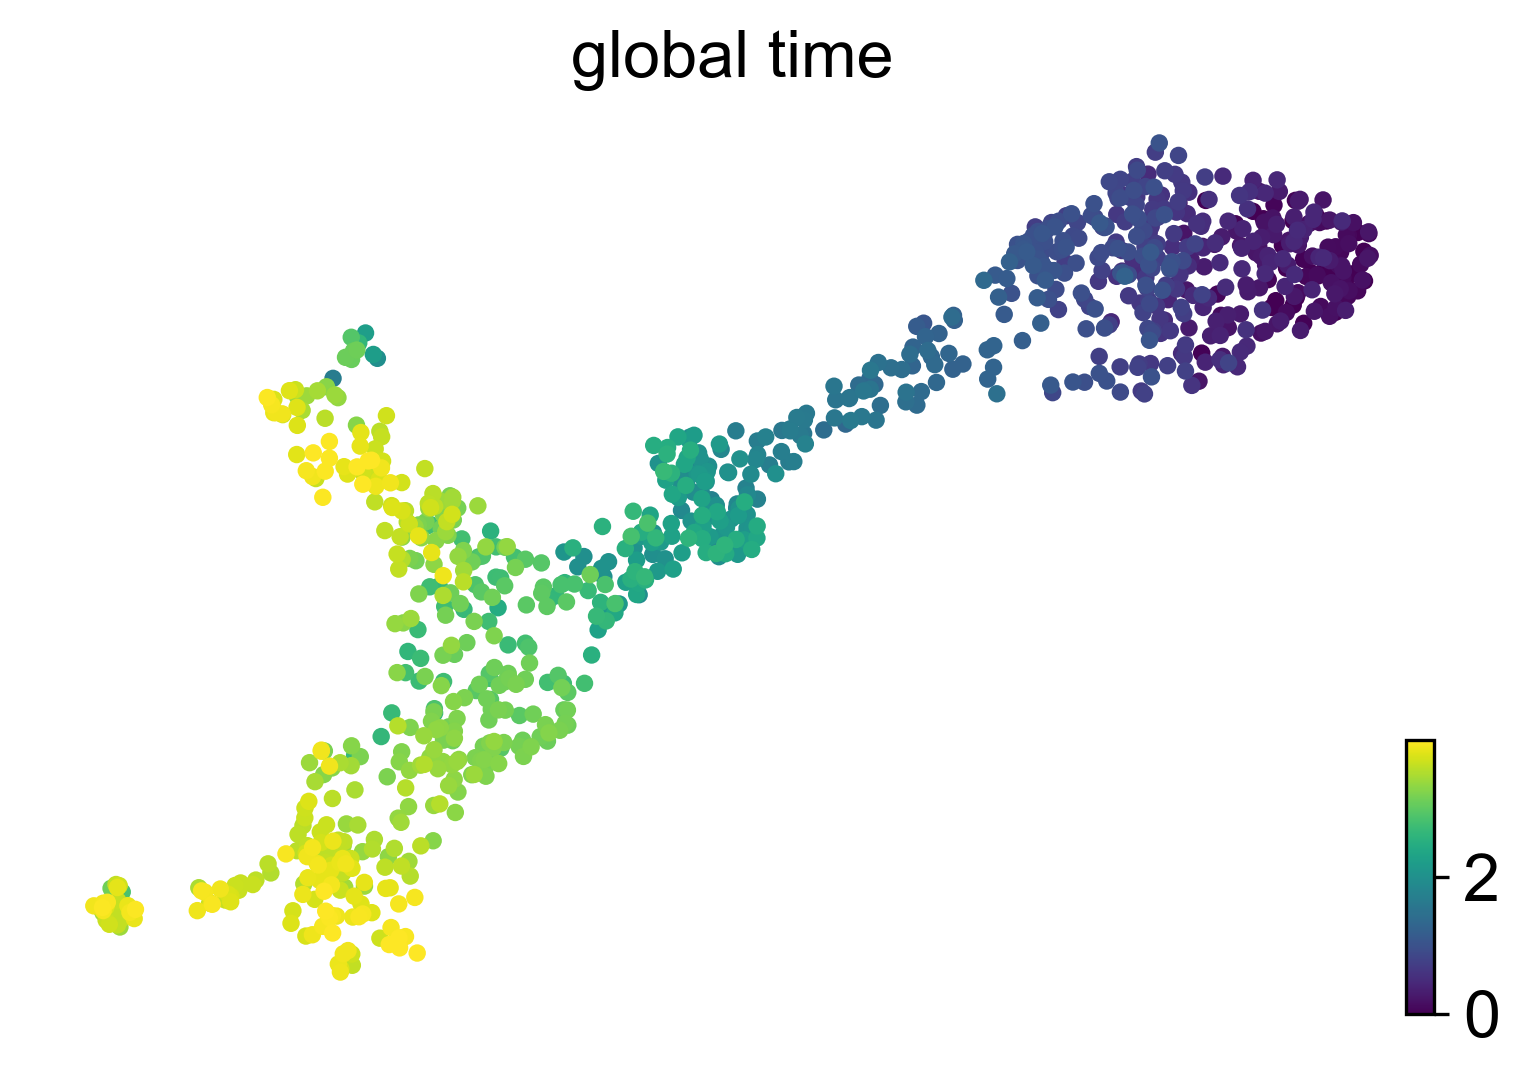

In [15]:
scv.pl.scatter(adata, color='global_time', color_map='viridis', dpi=150)

Copy the UMAP into the raw object

In [16]:
adata_raw.obsm['X_umap'] = adata.obsm['X_umap'].copy()

## Compute velocities

In [17]:
scv.pp.moments(adata, n_pcs=7 )

computing neighbors
    finished (0:00:00)
computing moments based on connectivities
    finished (0:00:00)


In [18]:
# adapt the same knn graph for the raw object and compute moments
adata_raw.obsp['connectivities'] = adata.obsp['connectivities'].copy()
adata_raw.obsp['distances'] = adata.obsp['distances'].copy()
adata_raw.uns['neighbors'] = adata.uns['neighbors'].copy()

scv.pp.moments(adata_raw, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00)


In [19]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:00:07)


In [20]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00)
computing velocity graph
    finished (0:00:00)


computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00)
computing latent time using root_cells as prior
    finished (0:00:00)


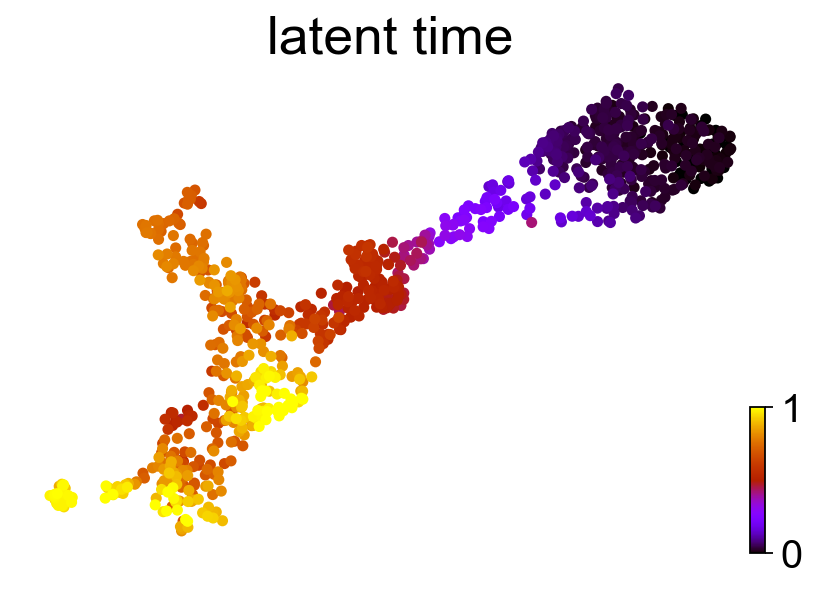

In [21]:
scv.tl.recover_latent_time(adata)

scv.pl.scatter(adata, color='latent_time', fontsize=24, size=100,
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0, 1])

computing velocity embedding
    finished (0:00:00)


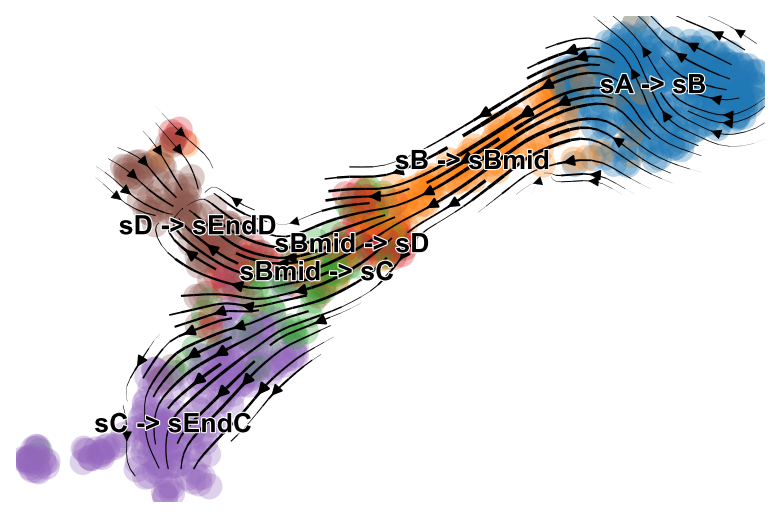

In [22]:
scv.pl.velocity_embedding_stream(adata, legend_fontsize=12, title='', smooth=0.8, min_mass=2.5, 
                                color='lineage')

## 3D Plotting

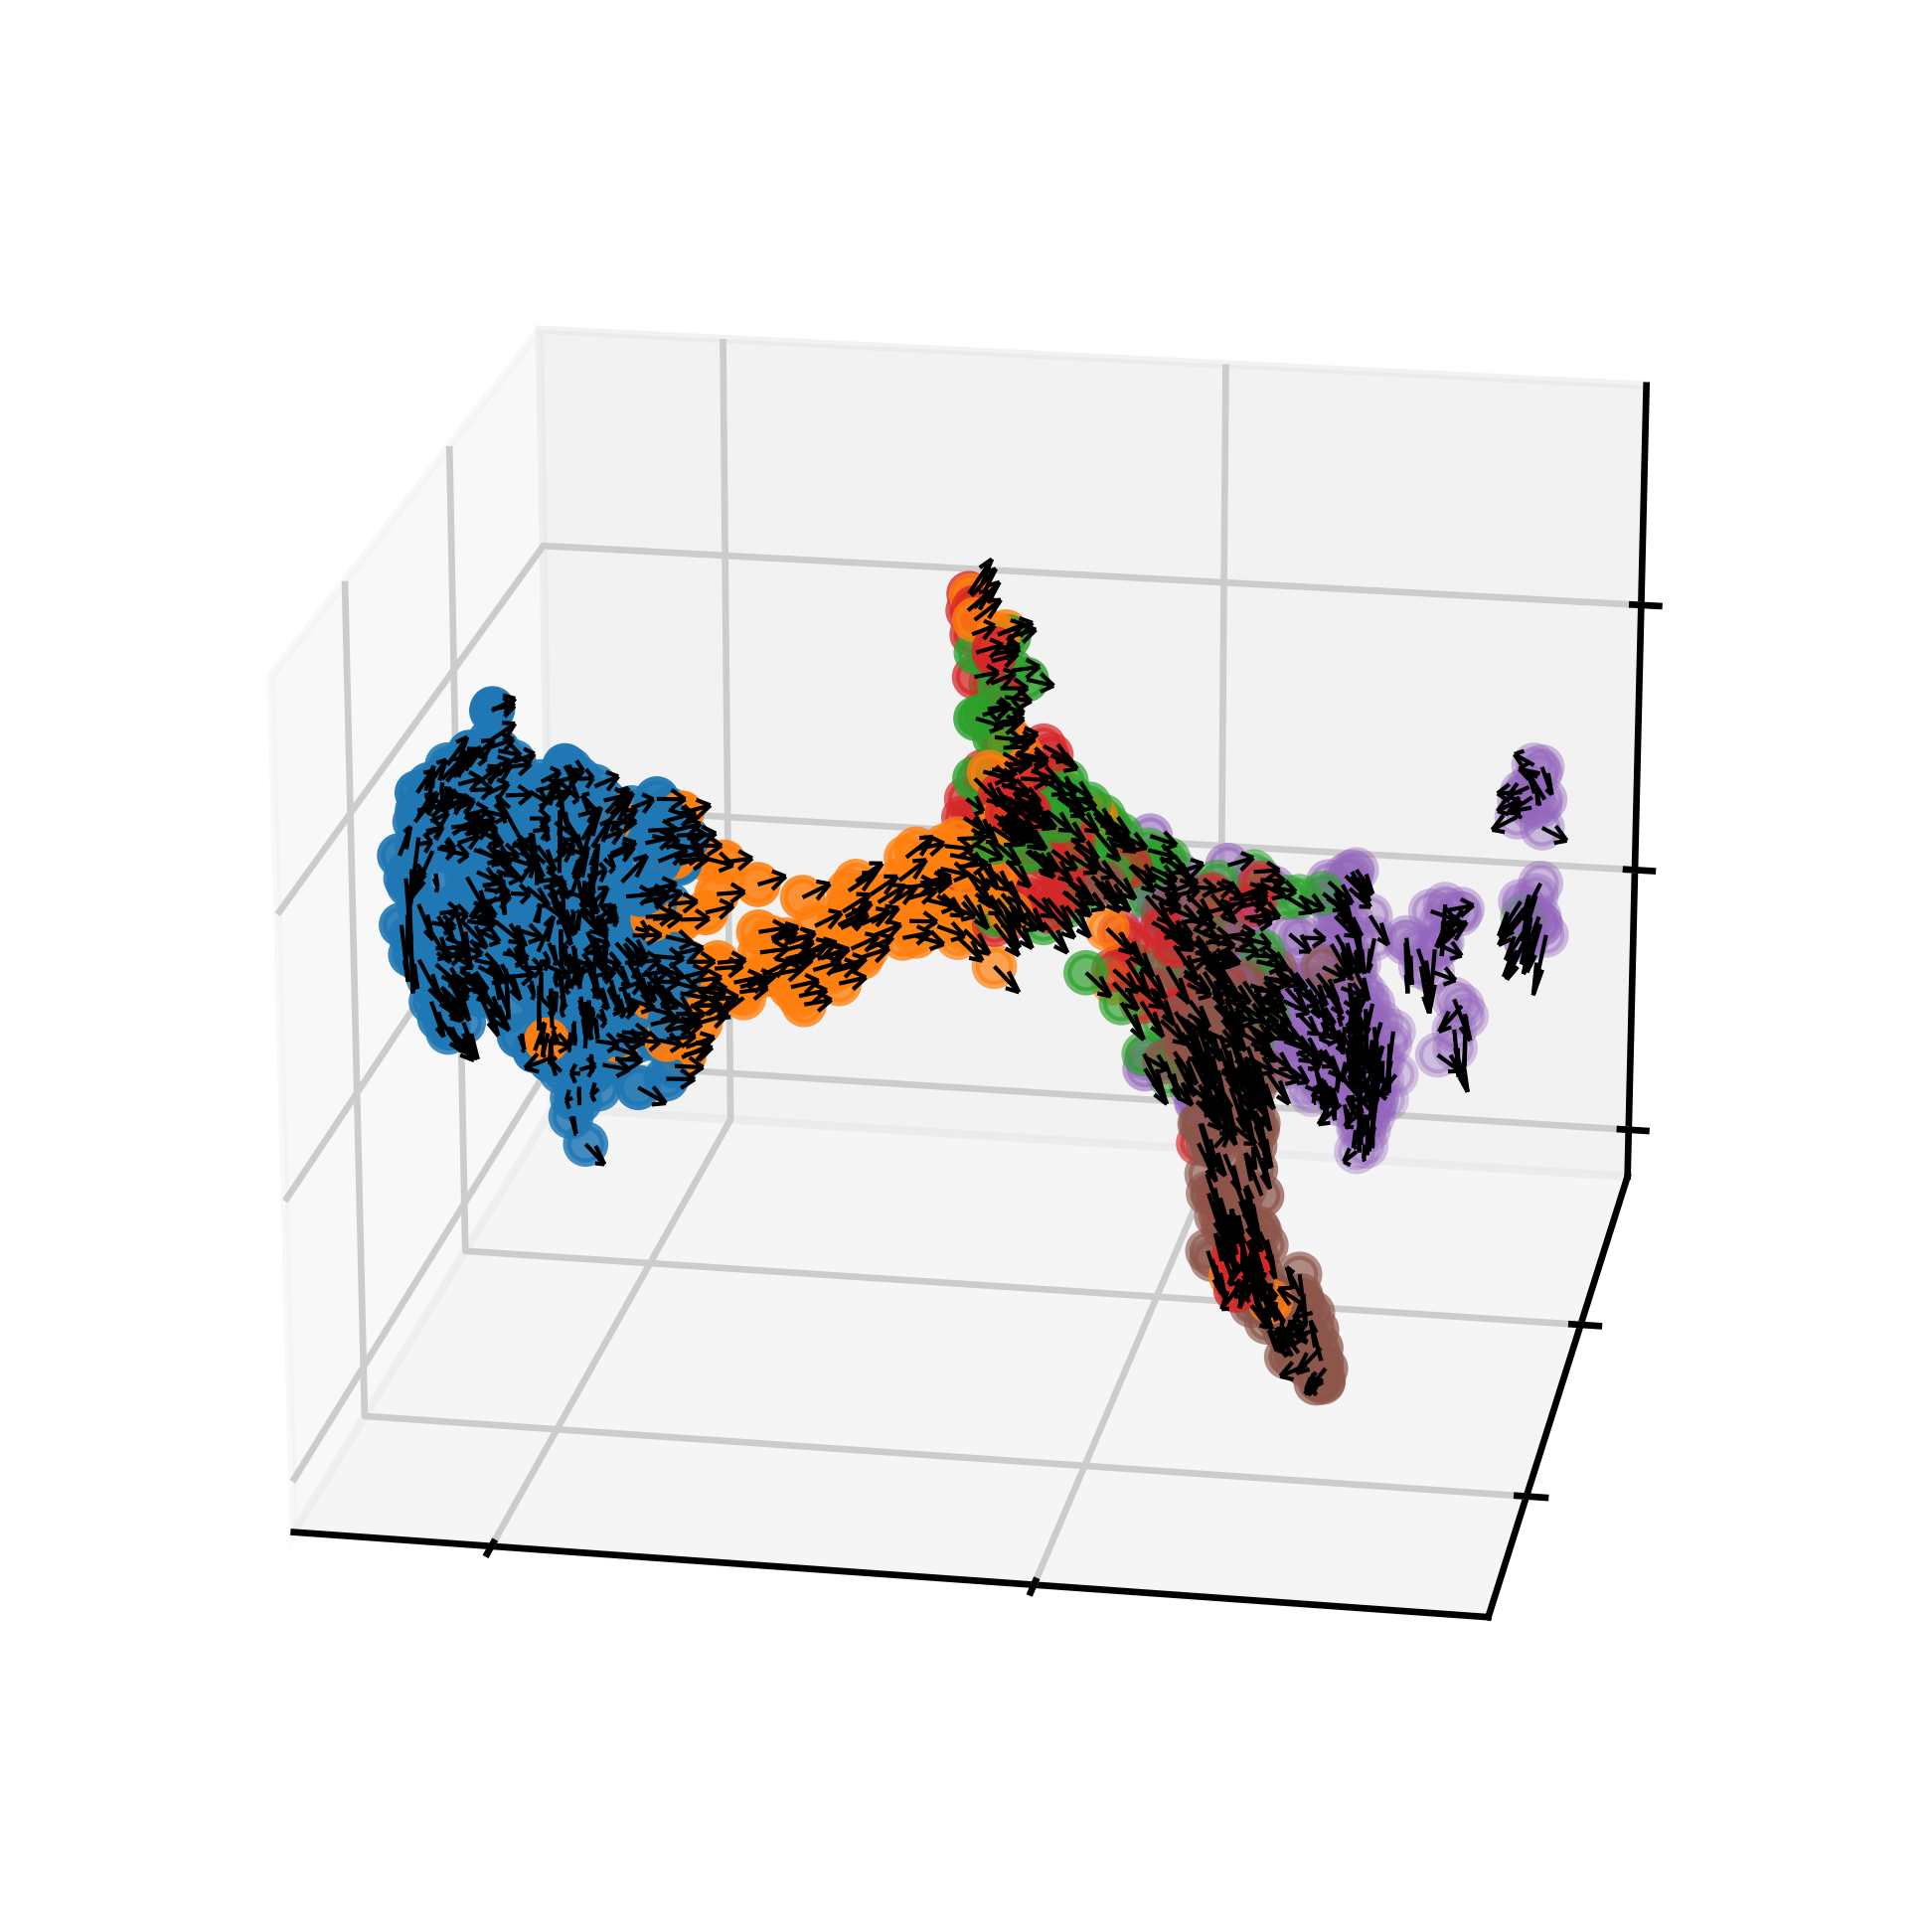

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
# %matplotlib notebook

umap = adata.obsm['X_umap']
velocity = adata.obsm['velocity_umap']
# color = adata.obs['global_time']
color = scv.utils.interpret_colorkey(adata, c="lineage")

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap[:, 0], umap[:, 1], umap[:, 2], c=color, cmap='viridis')

# prepare colors for the arrows (use black currently)
# c = scv.utils.interpret_colorkey(adata, c="lineage")
# c = list(c) + [element for element in list(c) for _ in range(2)]

# Plot the velocity projection
ax.quiver(umap[:, 0], umap[:, 1], umap[:, 2], velocity[:, 0], velocity[:, 1], velocity[:, 2], color='k',
          normalize=True, length=0.5, arrow_length_ratio=0.5, linewidth = 0.5)

ax.view_init(20, 100)

# turn off the axis ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# ax.set_xlabel('20k dimensions')
plt.savefig(f"{figdir}/high_dim_projection.pdf")
plt.show()

Easiest to get the legend: just plot using scvelo

saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures/concept_figure/new_embedding/concept_fig_lineage_labels.pdf


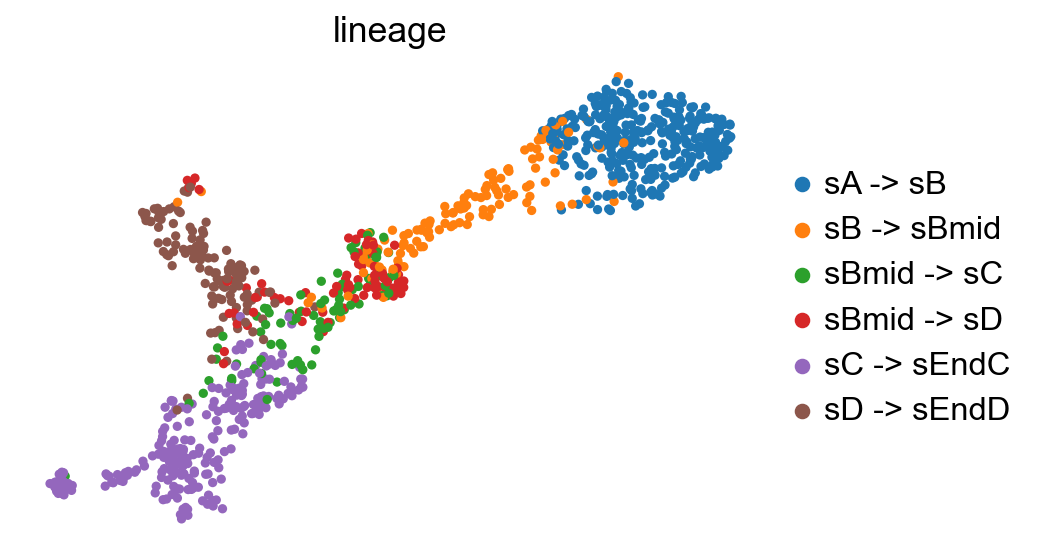

In [24]:
scv.pl.scatter(adata, color='lineage', legend_loc='right', save='lineage_labels.pdf')

Produce a grey colorbar using scvelo

saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures/concept_figure/new_embedding/concept_fig_colorbar.pdf


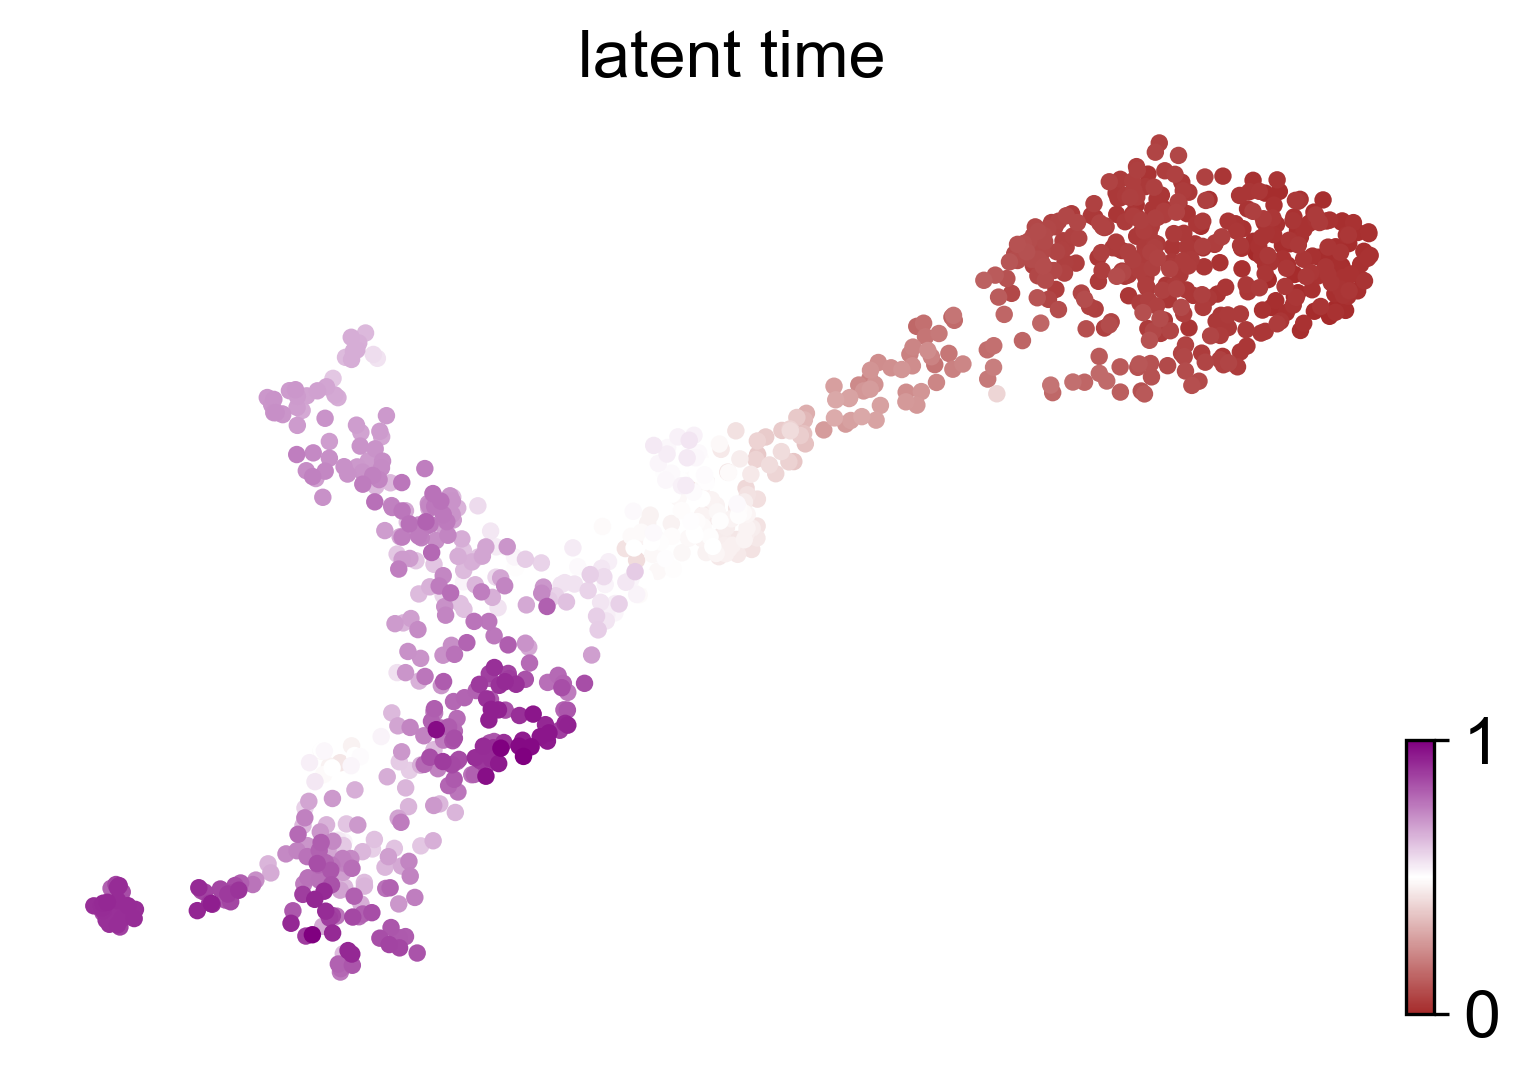

In [25]:
scv.pl.scatter(adata, color='latent_time', color_map = ['brown', 'white', 'purple'], save='colorbar.pdf', dpi=150)

# Run CellRank

## Compute initial and terminal states

We cache the actual transition matrix computation. This is faster. 

In [26]:
from cellrank.tl.estimators import GPCCA

c.tl.transition_matrix(adata, weight_connectivities=0.2, mode="stochastic", n_jobs=8, 
                                    softmax_scale=None, fname='transition_matrix_stochastic')

g_fwd = GPCCA(adata, obsp_key='T_fwd')

Loading data from: `transition_matrix_stochastic.pickle`.


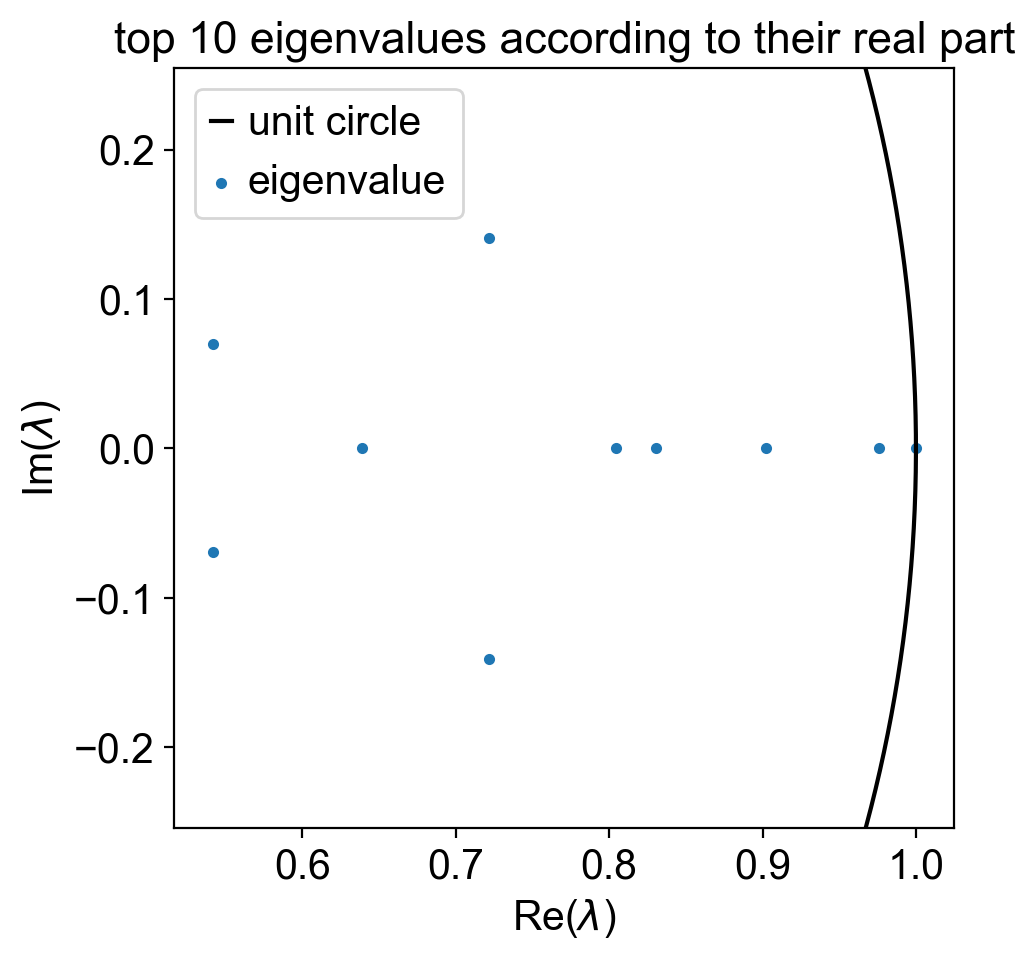

In [27]:
g_fwd.compute_schur()
g_fwd.plot_spectrum()

INFO: Using pre-computed schur decomposition
saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures/concept_figure/new_embedding/concept_fig_macrostates.pdf


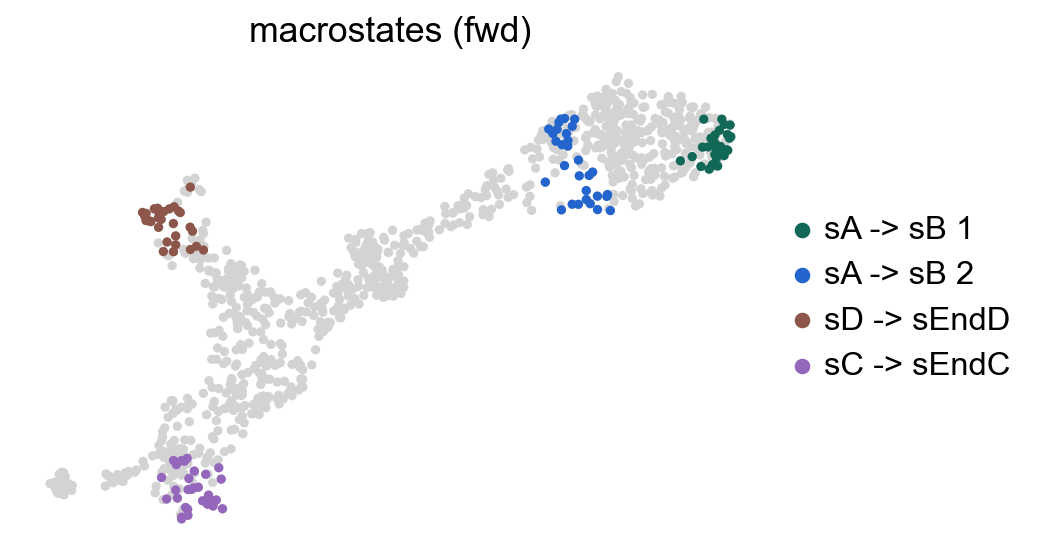

In [28]:
g_fwd.compute_macrostates(n_states=4, cluster_key='lineage')
g_fwd.plot_macrostates(discrete=True, save='macrostates', legend_loc='right')

Automatically determine initial and terminal states here.

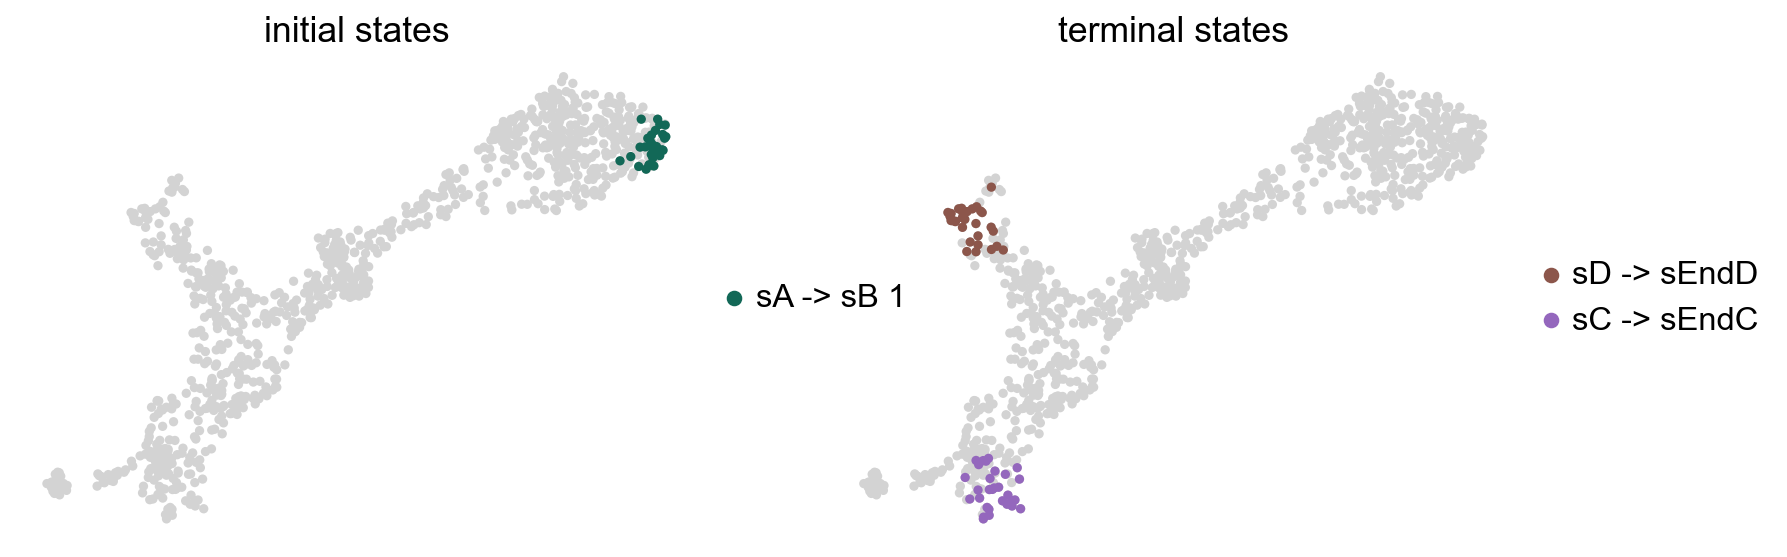

In [29]:
g_fwd.compute_terminal_states(method='stability')
g_fwd._compute_initial_states()


# plot using scvelo
scv.pl.scatter(adata, c=['initial_states', 'terminal_states'], legend_loc='right')

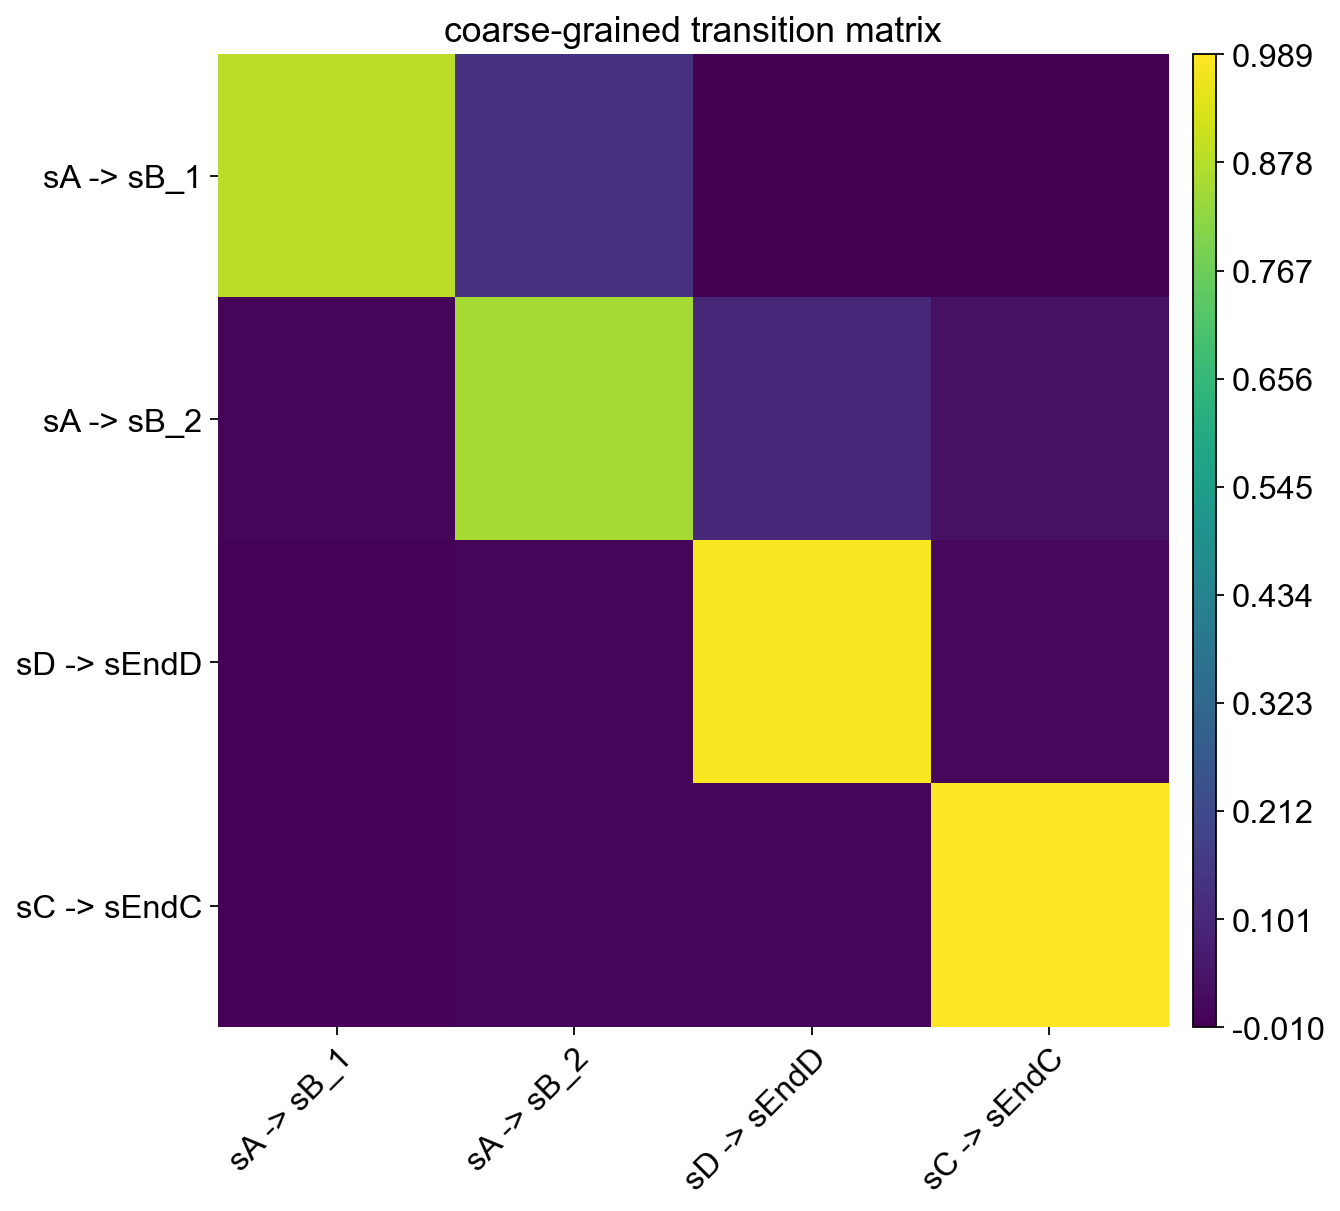

In [56]:
g_fwd.plot_coarse_T(save='transition_matrix_coarse.pdf', text_kwargs={'fontsize': 40}, 
                    show_stationary_dist=False, annotate=False, cmap='viridis')

## Plot the transition matrix

In [31]:
# get the transition matrix
T = adata.obsp['T_fwd'].A

# sort the cells by macrostate membership
meta_states_probs = g_fwd.macrostates_memberships
cell_assignment = meta_states_probs.argmax(1).X.flatten()
p = np.argsort(cell_assignment)
print(meta_states_probs.names)

['sA -> sB_1' 'sA -> sB_2' 'sD -> sEndD' 'sC -> sEndC']


Look at the distribution of non-zero values

<AxesSubplot:>

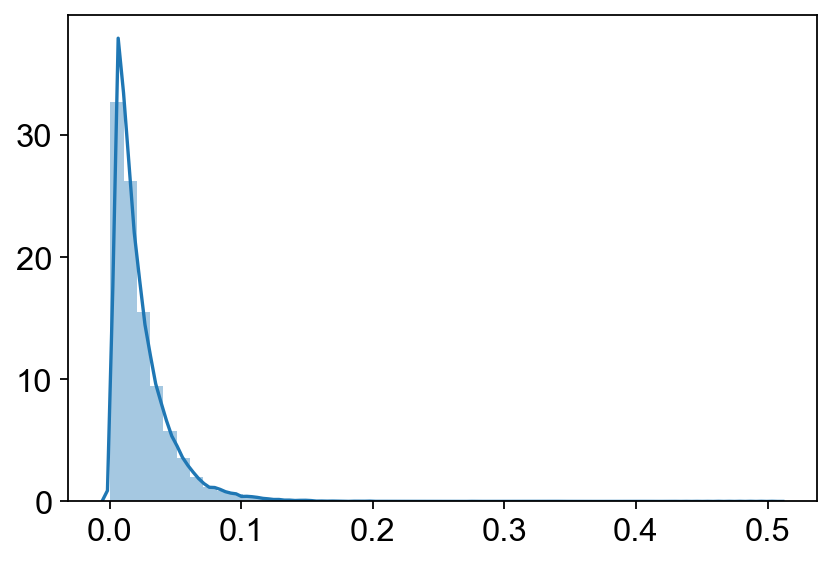

In [32]:
distplot(T[T>0])

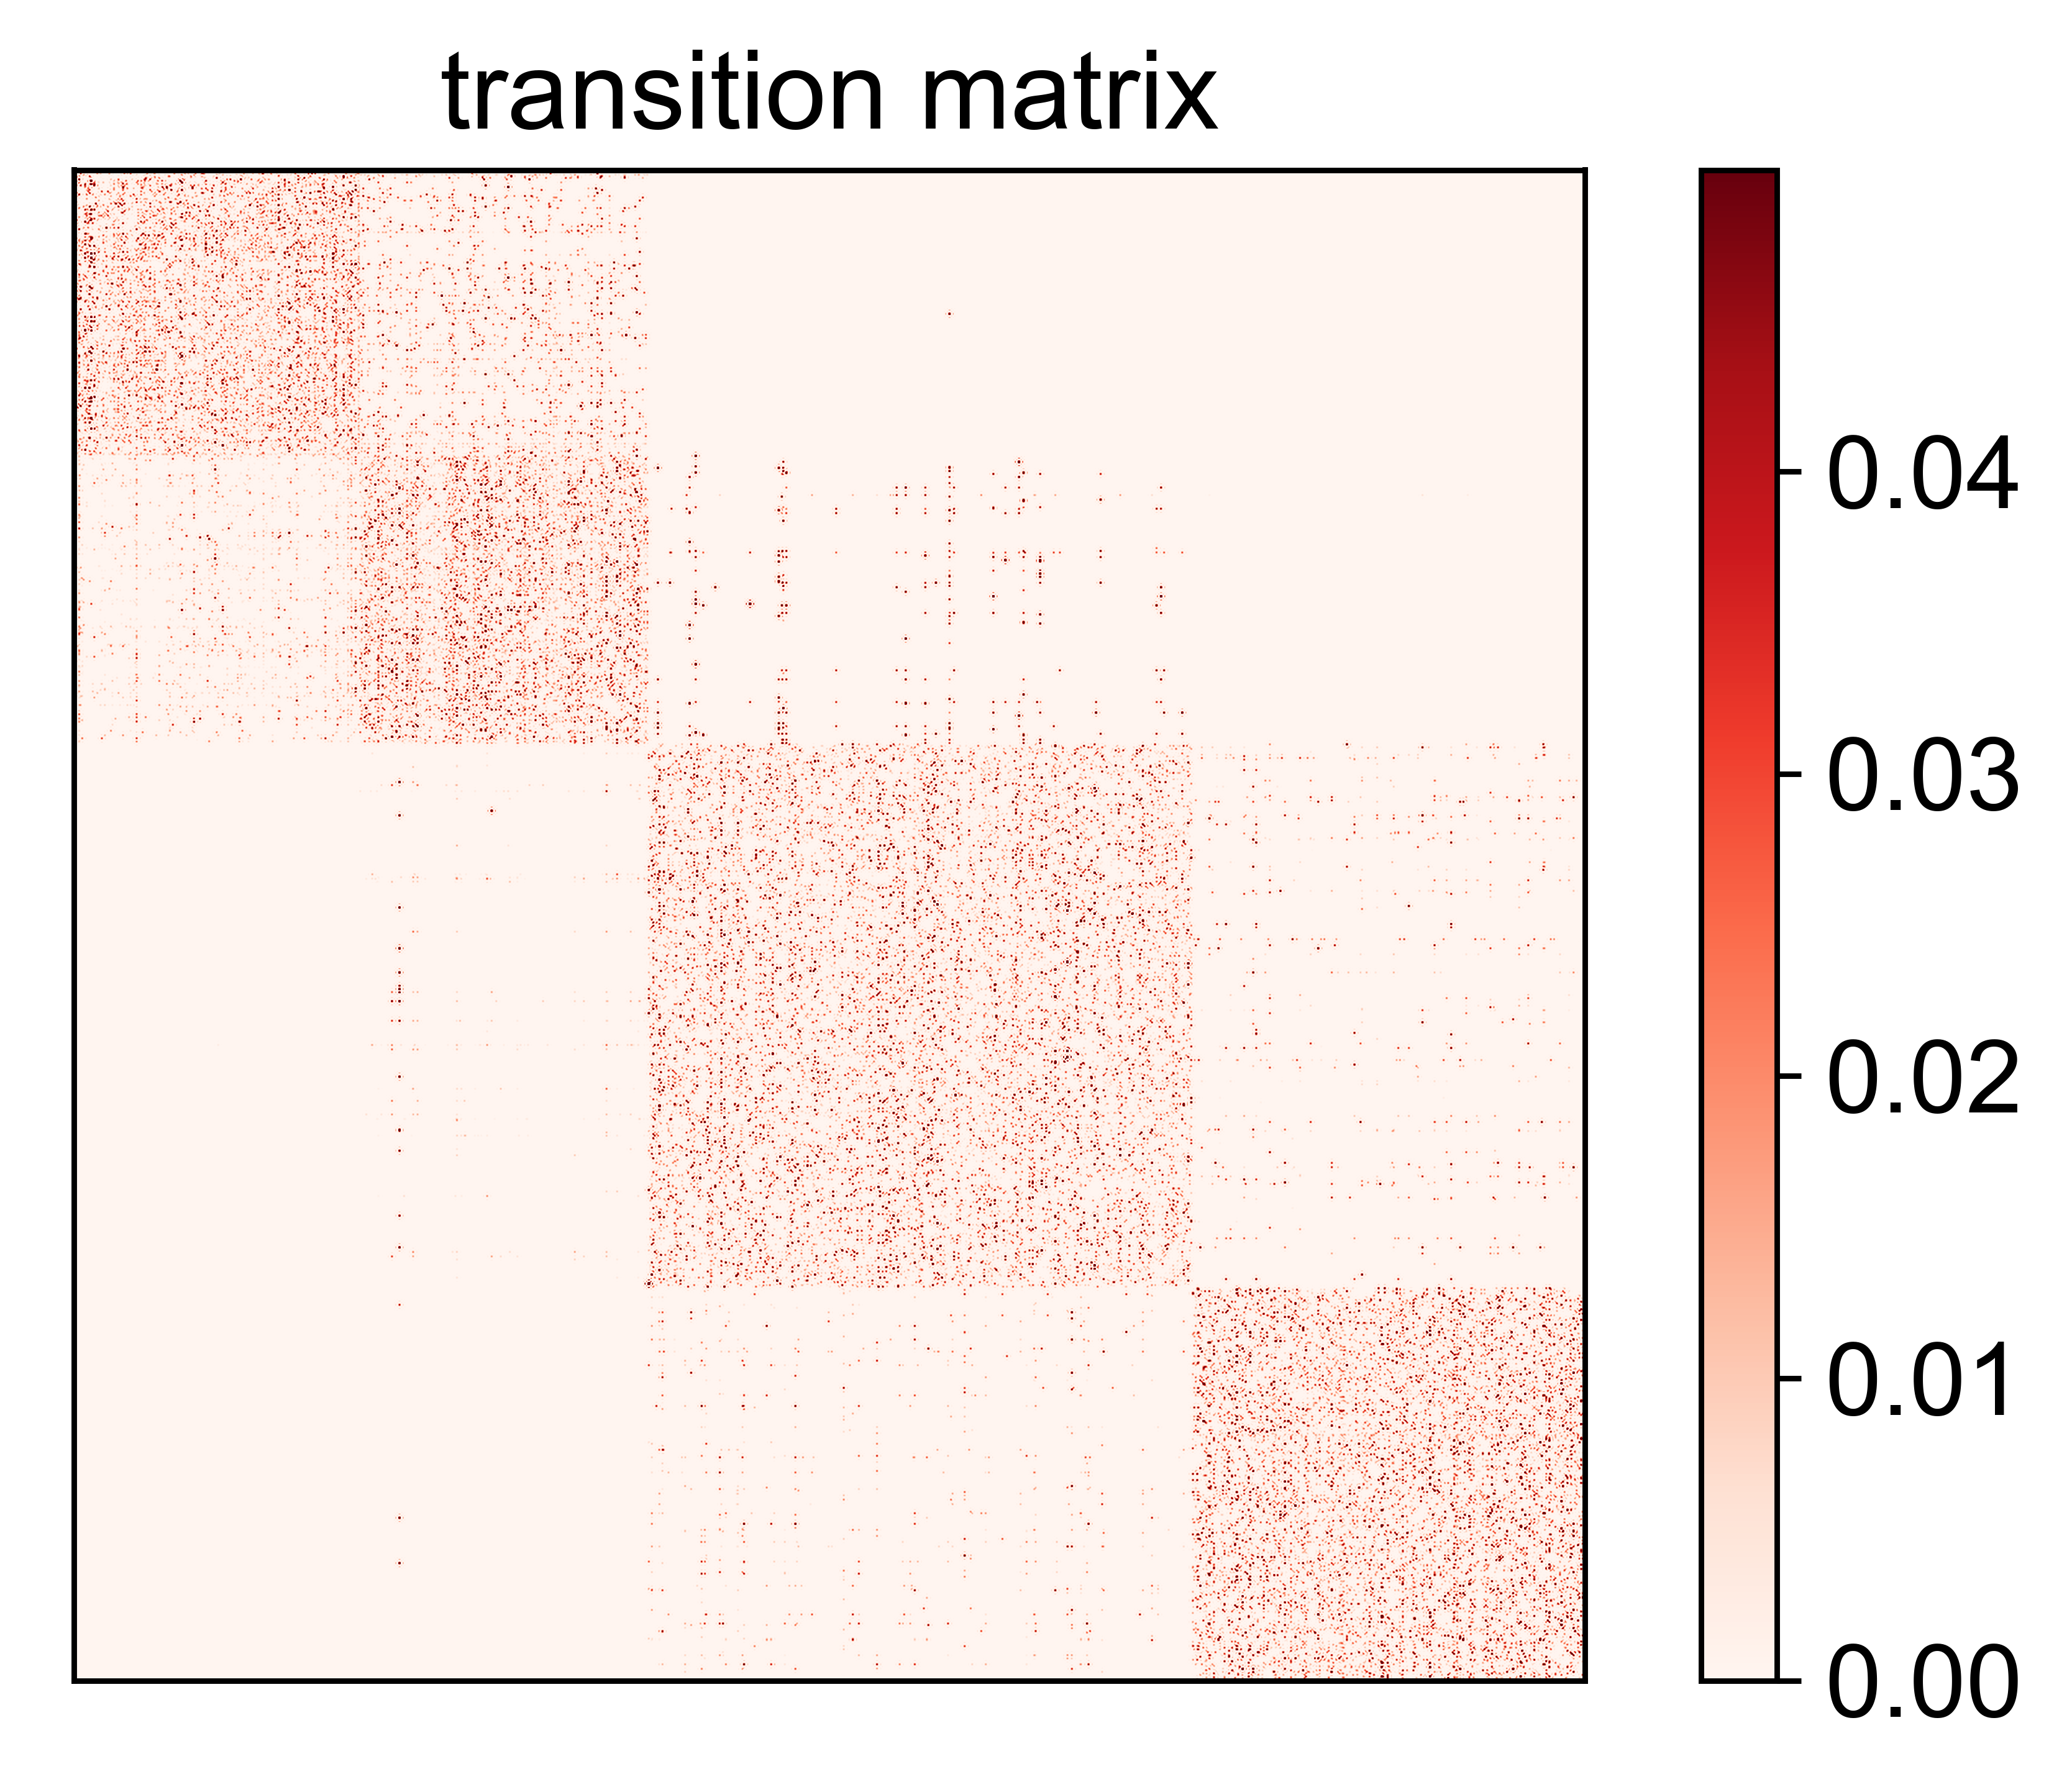

In [33]:
# takes ~ 5 min

vmax = np.quantile(T[T>0], 0.90)

fig = plt.figure(None, dpi=400)
ax = fig.add_subplot(111)

cax = ax.imshow(T[p ,:][:, p], vmin=0, vmax=vmax, cmap='Reds', interpolation='sinc', filterrad=4.0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('transition matrix')

plt.colorbar(mappable=cax)
plt.savefig(f"{figdir}/transition_matrix_by_metastate_values.pdf", bbox_inches='tight')
plt.show()

## Compute absorption probabilities

saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures/concept_figure/new_embedding/concept_fig_fate_map.pdf


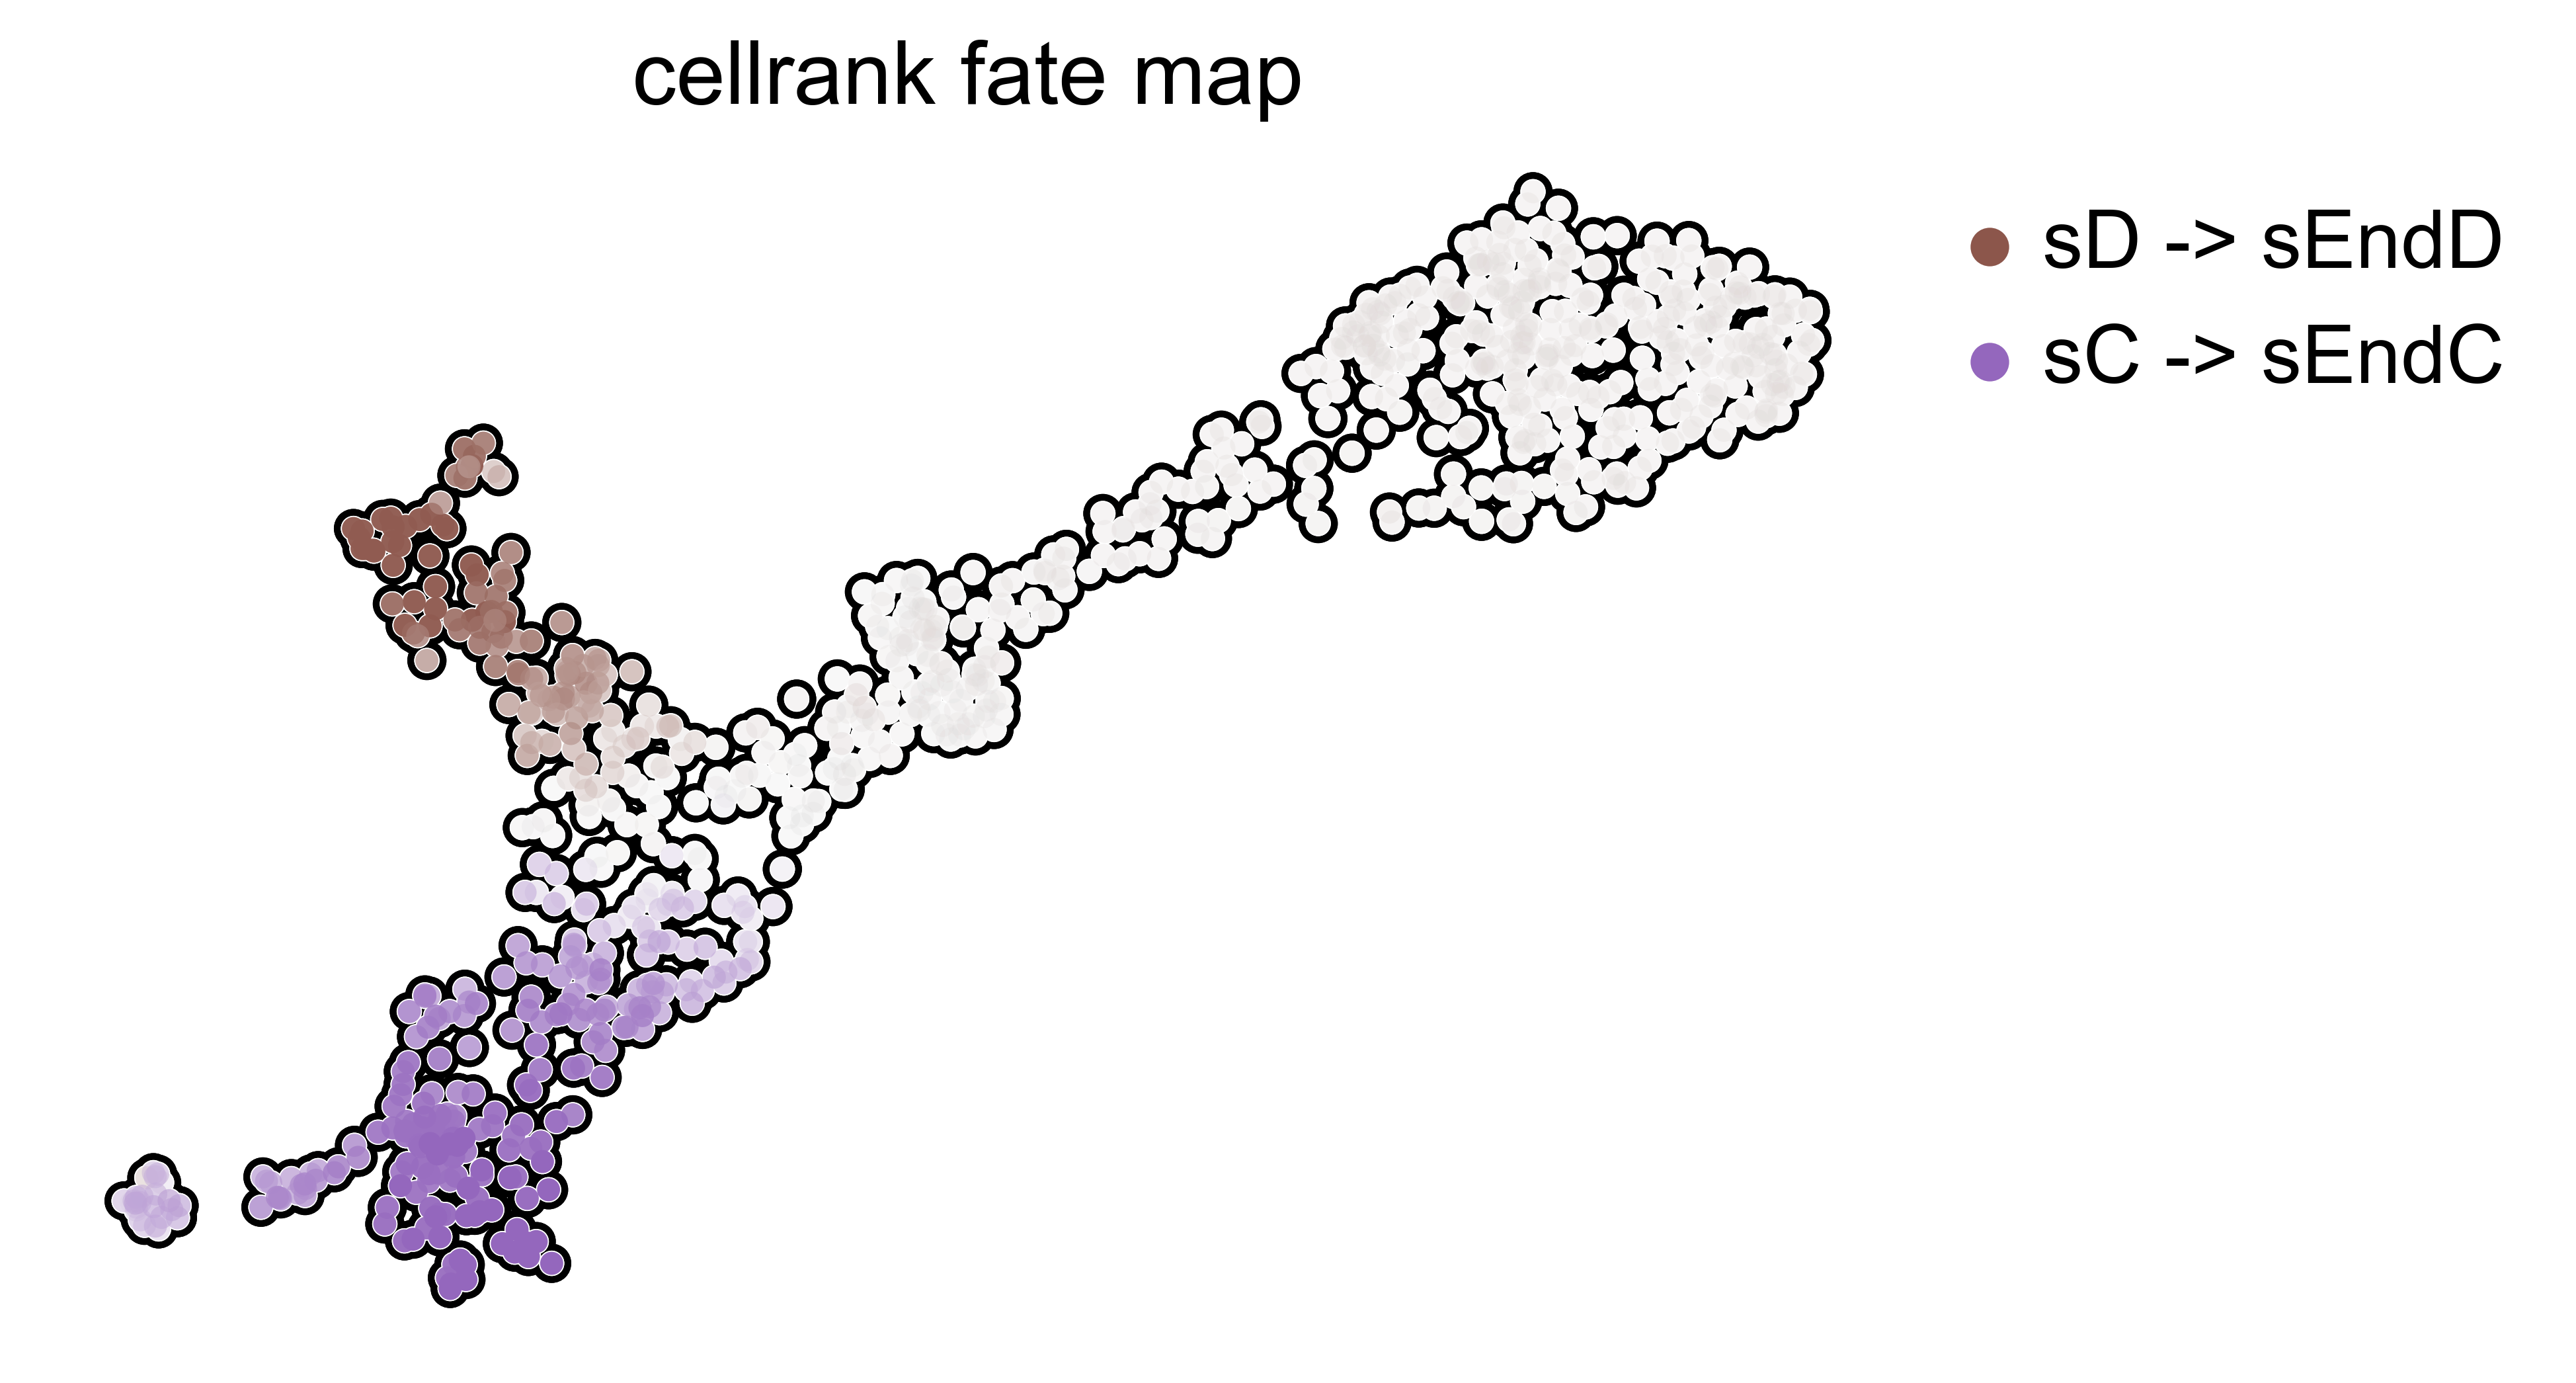

In [34]:
g_fwd.compute_absorption_probabilities(keys=['sD -> sEndD', 'sC -> sEndC'])
g_fwd.plot_absorption_probabilities(save='fate_map.pdf', dpi=300, title='cellrank fate map', add_outline=True)

## Gene expression trends

Prepare for plotting by copying over the lineage probabilities to the raw object.  

In [35]:
adata_raw.obsm['to_terminal_states'] = adata.obsm['to_terminal_states'].copy()
adata_raw.uns['terminal_states_colors'] = adata.uns['terminal_states_colors'].copy()
adata_raw.uns['to_terminal_states_colors'] = adata.uns['to_terminal_states_colors'].copy()

First thing we need to do is to compute moments based on more genes, so we have a selection of genes for plotting

saving figure to file /Users/marius/Projects/cellrank_notebooks_dev/figures/concept_figure/new_embedding/concept_fig_gene_expression_embedding.pdf


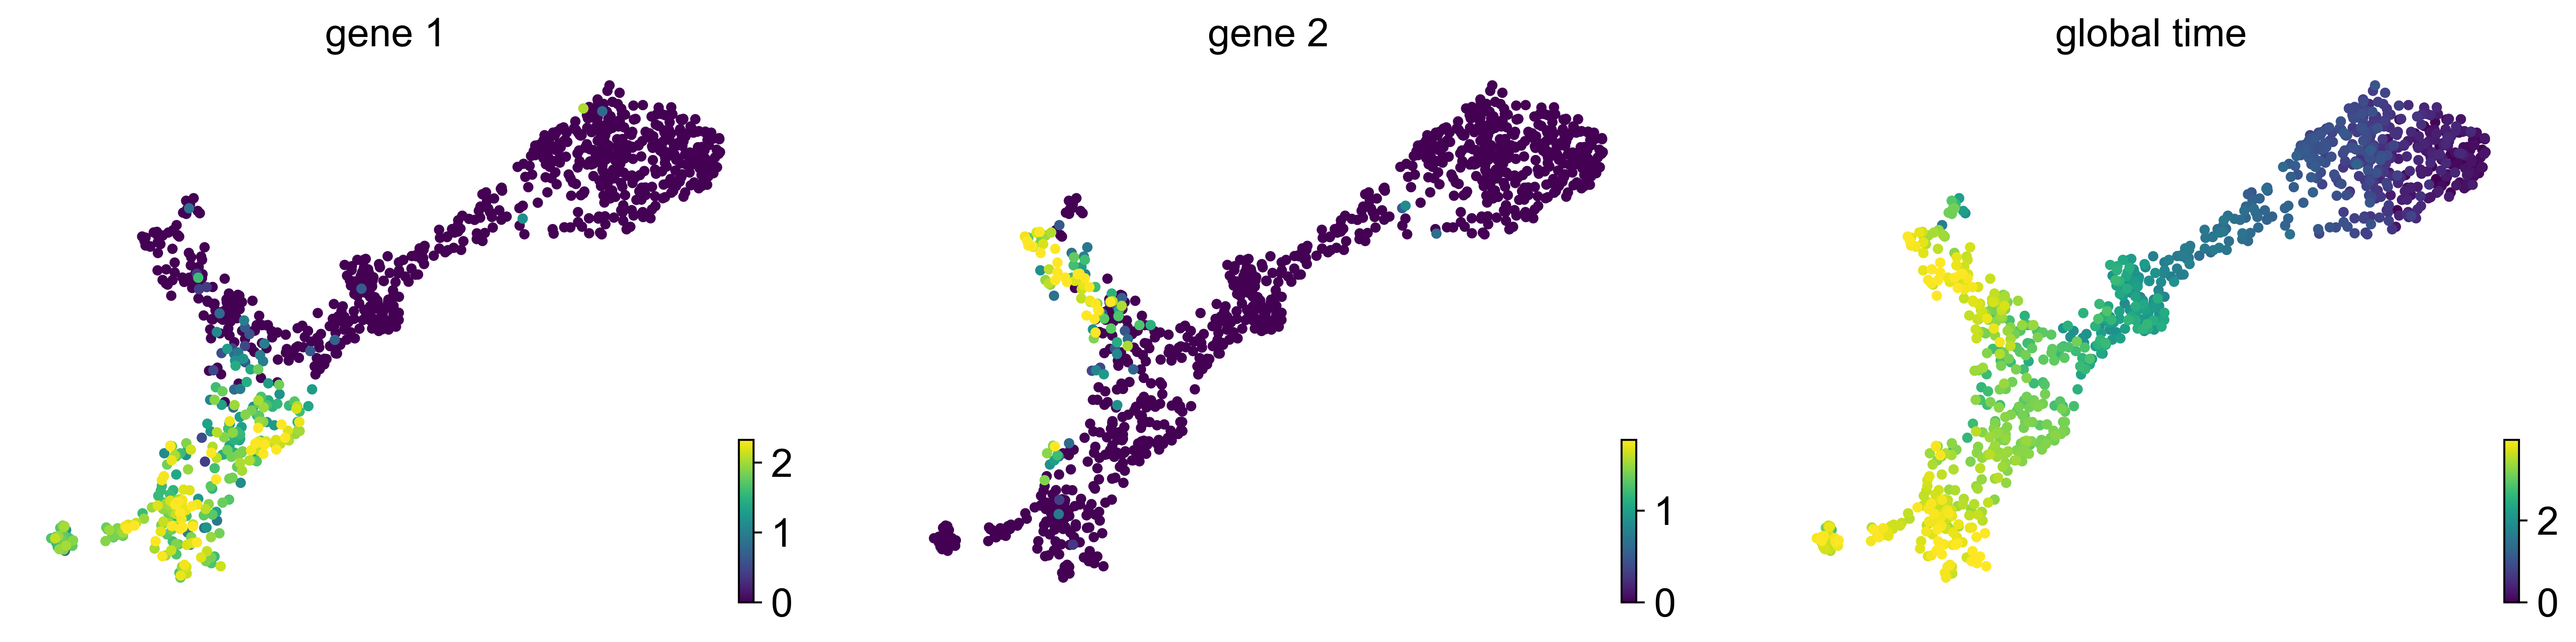

In [36]:
scv.pl.scatter(adata, color=['114','72', 'global_time'], perc=[0, 98], dpi=200,
               title=['gene 1', 'gene 2', 'global time'], 
              color_map='viridis', save='gene_expression_embedding.pdf')

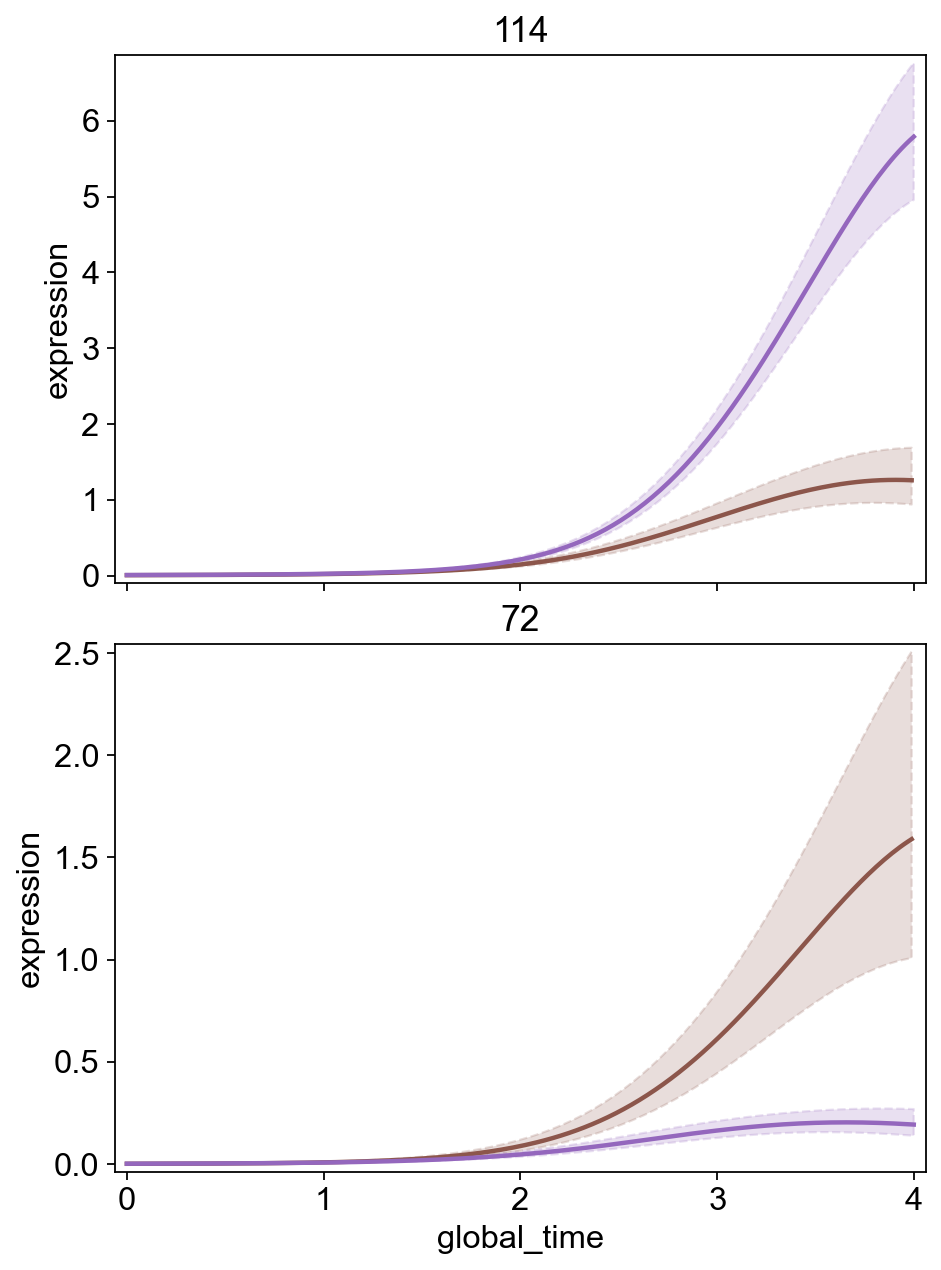

In [37]:
model = cr.ul.models.GAM(adata_raw, n_splines=6, spline_kwargs={'lam': 5})
cr.pl.gene_trends(adata_raw, model=model, data_key='Ms',
                  genes=['114', '72'], ncols=1, legend_loc=None,
                  time_key='global_time', same_plot=True, hide_cells=True, 
                  save='gene_expression_time.pdf')

## Look into potential driver genes

Find some genes which correlate well with fate probs

In [38]:
g_fwd.compute_lineage_drivers(use_raw=True)

Select a lineage and compute the heatmap

In [44]:
lin = 'sD -> sEndD'
corr = adata.raw.var.sort_values(by=f"to {lin}", ascending=False)

In [45]:
# filter the results to contain only highly variable genes
corr = corr.head(50)
# corr = corr[corr['n_cells'] > 150]
# corr = corr[corr['highly_variable']]
print(f"Selected {len(corr)} cells.")

Selected 50 cells.


did not converge



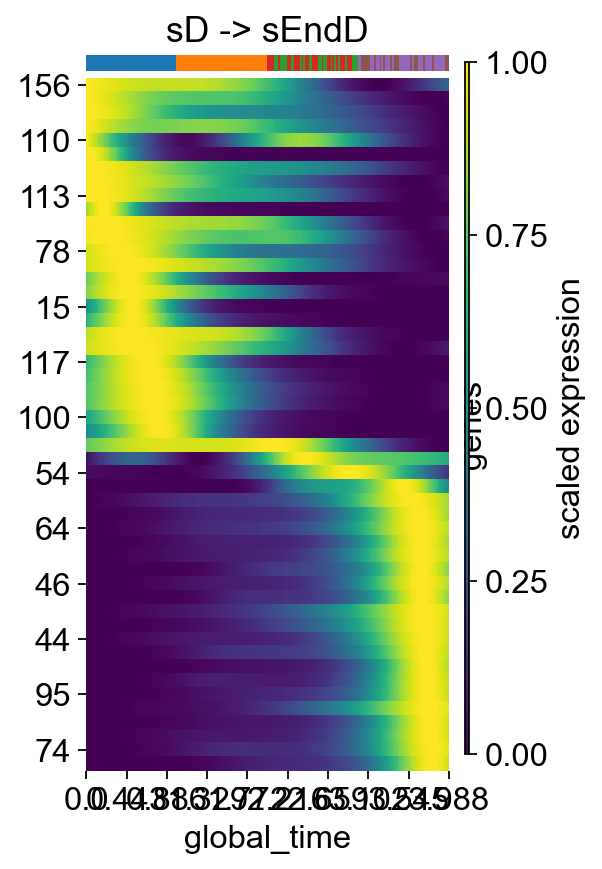

In [53]:
model = cr.ul.models.GAM(adata_raw, n_splines=10)
cr.pl.heatmap(adata_raw, model, genes=corr.index, lineages=[lin], 
              cluster_key='lineage', time_key='global_time', data_key='Ms',
              show_absorption_probabilities=False, figsize=(4, 6), show_all_genes=False, 
              weight_threshold=(0.05, 0.05)) 

Look at early, intermediate and late genes:

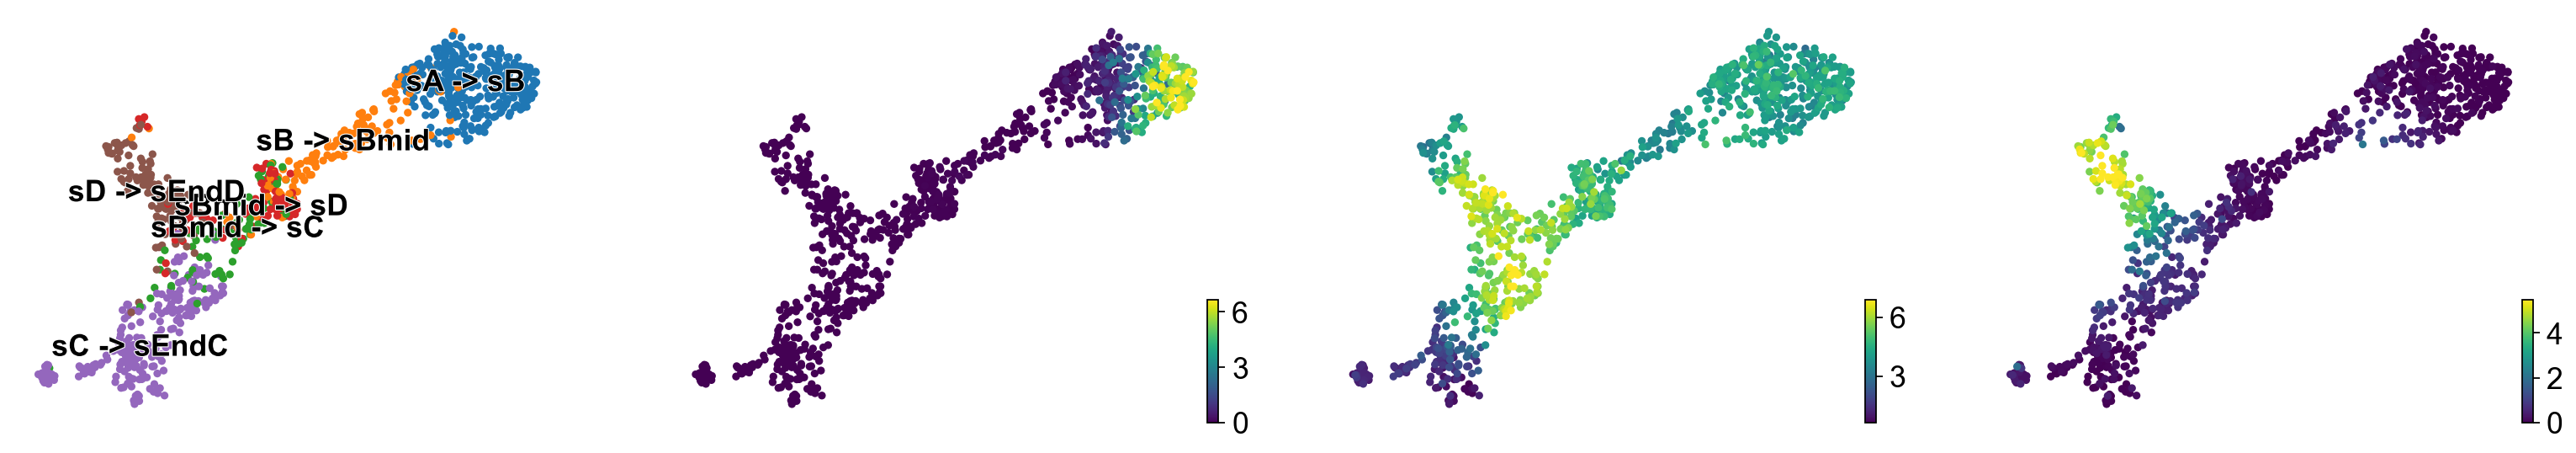

In [54]:
scv.pl.scatter(adata_raw, c=['lineage', '11', '54',  '43'], basis='umap', legend_loc='on data', 
               layer='Ms', perc=[0, 99], color_map='viridis', title='')